# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [3]:
!gdown 1K-ts35DZk6cmYpHW4Fvp49pS1Jopbzfz
!gdown 1KDcRfd8j5bpZCPDYluqBWJ8PD0g7lciC
!gdown 1h54bKa-L5i7ZG2E5FVK9-lO1pLIX5lj1
!gdown 1SYnFOkQmndLwZWpI_u3g311JrDJKxCYP

Downloading...
From: https://drive.google.com/uc?id=1K-ts35DZk6cmYpHW4Fvp49pS1Jopbzfz
To: /content/train.csv
100% 41.5M/41.5M [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KDcRfd8j5bpZCPDYluqBWJ8PD0g7lciC
To: /content/test.csv
100% 3.48M/3.48M [00:00<00:00, 23.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h54bKa-L5i7ZG2E5FVK9-lO1pLIX5lj1
To: /content/product.csv
100% 83.1k/83.1k [00:00<00:00, 3.50MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SYnFOkQmndLwZWpI_u3g311JrDJKxCYP
To: /content/geography.csv
100% 1.78M/1.78M [00:00<00:00, 16.3MB/s]


In [4]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

df_product = pd.read_csv('/content/product.csv')
df_geography = pd.read_csv('/content/geography.csv')

full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df = full_df.groupby('Date').agg({
    'Units': 'sum',
    'Revenue': 'sum',
    'COGS': 'sum'
}).reset_index()

full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df.sort_values('Date', inplace=True)

In [5]:
test_df_grouped = test_df.groupby('Date').agg({
    'Units': 'sum',
    'Revenue': 'sum',
    'COGS': 'sum'
}).reset_index()

test_df_grouped

,Date,Units,Revenue,COGS
0,2021-01-01,26,189558.81,1.539354e+05
1,2021-01-02,46,280406.70,2.539326e+05
2,2021-01-03,48,317656.08,2.703103e+05
3,2021-01-04,40,373463.37,3.165190e+05
4,2021-01-05,3,31120.11,2.249643e+04
...,...,...,...,...
530,2022-06-27,217,1616498.73,1.434694e+06
531,2022-06-28,263,2024019.27,1.763163e+06
532,2022-06-29,282,2265602.85,1.971644e+06
533,2022-06-30,67,700389.90,6.056699e+05


In [6]:
full_df.index = full_df['Date']
full_df.drop('Date', axis=1, inplace=True)

In [7]:
full_df.head()

,Units,Revenue,COGS
Date,,,
2010-07-04,252,1765391.67,1.340364e+06
2010-07-05,208,1425986.10,1.112580e+06
2010-07-06,33,302463.00,2.373014e+05
2010-07-07,181,1047787.65,8.425688e+05
2010-07-08,121,771811.74,6.028101e+05


# Scaler

In [8]:
days_of_week = np.array([i % 7 for i in range(len(full_df))]).reshape(-1, 1)

In [9]:
features = np.hstack((full_df[['Units', 'COGS']], days_of_week))
target = full_df['Revenue']

# target = np.log1p(target)

target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

features_scaler = MinMaxScaler()
features_scaled = features_scaler.fit_transform(features)

dataset = np.hstack((features_scaled, target_scaled))

# Split Sequence

In [10]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
n_steps_in, n_steps_out = 30, 1
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features = X.shape[2]

In [12]:
test_size = 535
train_size = len(X) - test_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Define stacked LSTM model class

In [13]:
class RevenueLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RevenueLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize hidden and cell states for all three LSTM layers
        h1 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c1 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        h2 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c2 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        h3 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c3 = torch.zeros(1, batch_size, self.hidden_size).to(device)

        # Forward pass through LSTM layers with dropout
        out, (h1, c1) = self.lstm1(x, (h1, c1))
        out = self.dropout1(out)
        out, (h2, c2) = self.lstm2(out, (h2, c2))
        out = self.dropout2(out)
        out, (h3, c3) = self.lstm3(out, (h3, c3))
        out = self.dropout3(out)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
model = RevenueLSTM(n_features, hidden_size=200, output_size=n_steps_out).to(device)

# Train the Model

In [15]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()  # Use MSE as the base

    def forward(self, y_pred, y_true):
        mse_loss = self.mse(y_pred, y_true)  # Compute MSE
        rmse_loss = torch.sqrt(mse_loss)     # Take square root to get RMSE
        return rmse_loss

!gdown 1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x
from adopt import ADOPT

Downloading...
From (original): https://drive.google.com/uc?id=1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x
From (redirected): https://drive.google.com/uc?id=1y8xhCM_rVCgxOPSF3VtVkFxnwxtBlH0x&confirm=t&uuid=b2102f3c-461d-423e-bc73-cf56b850fdc8
To: /content/adopt.py
100% 18.3k/18.3k [00:00<00:00, 54.7MB/s]


In [16]:
criterion = RMSELoss()
optimizer = ADOPT(model.parameters(), lr=0.001, weight_decay=1e-5)

In [17]:
num_epochs = 1000
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            test_loss += criterion(outputs, batch_y).item()
    test_loss /= len(test_loader)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pt', _use_new_zipfile_serialization=False)  # Avoid pickle issues

model.load_state_dict(torch.load('best_model.pt', weights_only=True))

Epoch [100/1000], Train Loss: 0.0394, Test Loss: 0.0329
Epoch [200/1000], Train Loss: 0.0288, Test Loss: 0.0317
Epoch [300/1000], Train Loss: 0.0252, Test Loss: 0.0312
Epoch [400/1000], Train Loss: 0.0240, Test Loss: 0.0340
Epoch [500/1000], Train Loss: 0.0233, Test Loss: 0.0335
Epoch [600/1000], Train Loss: 0.0190, Test Loss: 0.0334
Epoch [700/1000], Train Loss: 0.0399, Test Loss: 0.0379
Epoch [800/1000], Train Loss: 0.0247, Test Loss: 0.0342
Epoch [900/1000], Train Loss: 0.0232, Test Loss: 0.0372
Epoch [1000/1000], Train Loss: 0.0193, Test Loss: 0.0333


<All keys matched successfully>

# Test the Model

In [18]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(torch.FloatTensor(X_test).to(device))

    # Reverse scaling and log transform
    y_pred = target_scaler.inverse_transform(y_pred_scaled.cpu().numpy())
    # y_pred = np.expm1(y_pred_log)
    y_test = target_scaler.inverse_transform(y_test)
    # y_test_unscaled = np.expm1(y_test_log)

y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

In [19]:
r2 = r2_score(y_test_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat)

print(f'R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}')

R2: 0.6549, MAPE: 0.5857, RMSE: 590015.9317


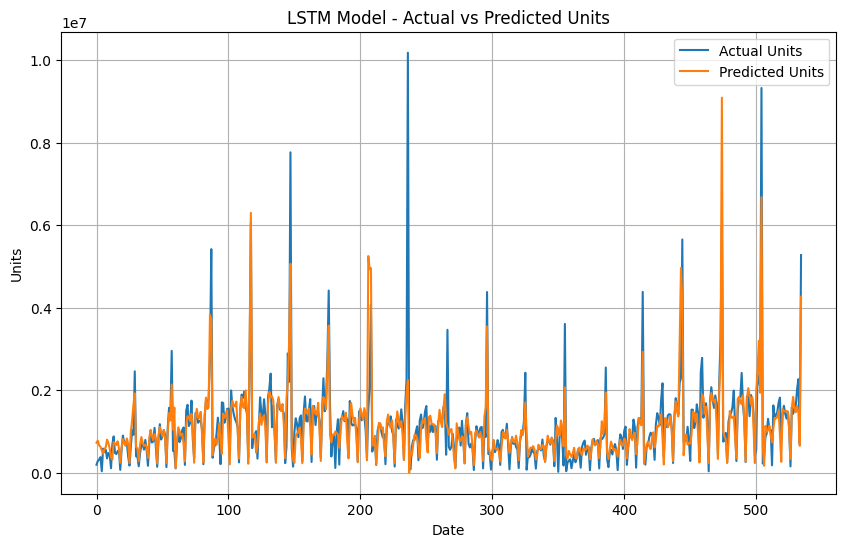

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(test_df_grouped.index, y_test_flat, label='Actual Units')
plt.plot(test_df_grouped.index, y_pred_flat, label='Predicted Units', linestyle='-')
plt.title('LSTM Model - Actual vs Predicted Units')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True)
plt.show()